In [1]:
# ============================================================
# WORKSHOP 4 - SIMULATION 2: EVENT-BASED CELLULAR AUTOMATA
# HCT Survival Equity System Analysis
# ============================================================
# Simulates patient outcomes using a grid where each cell is a patient.
# States: Stable (0), At Risk (1), Event (2 - death/relapse)
# ============================================================

In [2]:
# ==============================================================
# CELL 1: Clone Repository and Setup
# ==============================================================
# For Google Colab - skip if running locally with data already downloaded
# ==============================================================
import os

%cd /content

# Remove old data if exists
if os.path.exists('HCT_Survival_Equity_System_Analysis'):
    ! rm -rf HCT_Survival_Equity_System_Analysis

# Clone and navigate to workshop folder
! git clone https://github.com/SaiLord28/HCT_Survival_Equity_System_Analysis.git
%cd HCT_Survival_Equity_System_Analysis/4_workshop

print("Repository cloned successfully")
print("\nFiles in data/:")
! ls -la data/

/content
Cloning into 'HCT_Survival_Equity_System_Analysis'...
remote: Enumerating objects: 215, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 215 (delta 5), reused 12 (delta 3), pack-reused 192 (from 1)
Receiving objects: 100% (215/215), 26.13 MiB | 18.14 MiB/s, done.
Resolving deltas: 100% (74/74), done.
/content/HCT_Survival_Equity_System_Analysis/4_workshop
Repository cloned successfully

Files in data/:
total 9656
drwxr-xr-x 2 root root    4096 Nov 28 22:21 .
drwxr-xr-x 3 root root    4096 Nov 28 22:21 ..
-rw-r--r-- 1 root root    6006 Nov 28 22:21 data_dictionary.csv
-rw-r--r-- 1 root root 9868662 Nov 28 22:21 train.csv


In [3]:
# ==============================================================
# CELL 2: Install Dependencies
# ==============================================================
!pip install pandas numpy matplotlib seaborn -q

print("Dependencies installed successfully")

Dependencies installed successfully


In [4]:
# ==============================================================
# CELL 3: Imports and Configuration
# ==============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Simulation parameters
RANDOM_STATE = 42
CA_GRID_SIZE = 40          # 40x40 grid = 1,600 patients
CA_STEPS = 80              # Number of time steps
CA_RECOVERY_FACTOR = 0.08  # Chance of at-risk patient recovering
CA_PROGRESSION_FACTOR = 0.12  # Chance of at-risk patient having event
CA_CHAOS_FACTOR = 0.03     # Chance of stable patient getting complications

np.random.seed(RANDOM_STATE)

print("Dependencies loaded successfully")

Dependencies loaded successfully


In [5]:
# ==============================================================
# CELL 4: Load Data for Initial Distribution
# ==============================================================
# Use real event rate from data to initialize the simulation
# ==============================================================
df = pd.read_csv('data/train.csv')

# Handle string or numeric target column
if df['efs'].dtype == 'object':
    event_rate = (df['efs'] == 'Event').mean()
else:
    event_rate = df['efs'].mean()

print(f"Dataset: {df.shape[0]} rows")
print(f"Event rate in real data: {event_rate:.4f}")

Dataset: 28800 rows
Event rate in real data: 0.5393


In [6]:
# ==============================================================
# CELL 5: Cellular Automata Class Definition
# ==============================================================
class HCTCellularAutomata:
    """
    Cellular Automata for post-HCT survival simulation.
    
    States: 0=Stable, 1=At Risk, 2=Event (absorbing)
    """

    def __init__(self, grid_size=40, event_rate=0.25):
        self.grid_size = grid_size
        self.event_rate = event_rate
        self.grid = self._initialize_grid()
        self.history = [self.grid.copy()]
        self.statistics = []

    def _initialize_grid(self):
        """Create initial grid with random patient states."""
        grid = np.zeros((self.grid_size, self.grid_size), dtype=int)
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                rand = np.random.random()
                if rand < self.event_rate:
                    grid[i, j] = 2  # Event
                elif rand < self.event_rate + 0.35:
                    grid[i, j] = 1  # At Risk
                else:
                    grid[i, j] = 0  # Stable
        return grid

    def _count_neighbors(self, x, y, state):
        """Count neighbors in a given state (uses wrap-around boundaries)."""
        count = 0
        for i in range(-1, 2):
            for j in range(-1, 2):
                if i == 0 and j == 0:
                    continue
                ni, nj = (x + i) % self.grid_size, (y + j) % self.grid_size
                if self.grid[ni, nj] == state:
                    count += 1
        return count

    def apply_rules(self, recovery_factor, progression_factor, chaos_factor):
        """Apply transition rules to all cells."""
        new_grid = self.grid.copy()
        
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                current_state = self.grid[i, j]
                neighbors_stable = self._count_neighbors(i, j, 0)
                neighbors_risk = self._count_neighbors(i, j, 1)
                neighbors_event = self._count_neighbors(i, j, 2)

                if current_state == 0:  # Stable
                    if neighbors_risk >= 3 or neighbors_event >= 2:
                        new_grid[i, j] = 1
                    elif np.random.random() < chaos_factor:
                        new_grid[i, j] = 1
                        
                elif current_state == 1:  # At Risk
                    if neighbors_event >= 4:
                        new_grid[i, j] = 2
                    elif np.random.random() < progression_factor:
                        new_grid[i, j] = 2
                    elif neighbors_stable >= 5 and np.random.random() < recovery_factor:
                        new_grid[i, j] = 0
                        
                # State 2 (Event) is absorbing - no change

        self.grid = new_grid
        self.history.append(self.grid.copy())

    def run_simulation(self, steps, recovery_factor, progression_factor, chaos_factor, verbose=True):
        """Run simulation for given number of steps."""
        if verbose:
            print(f"   Grid size: {self.grid_size}x{self.grid_size}")
            print(f"   Steps: {steps}")
            print(f"   Factors: recovery={recovery_factor}, progression={progression_factor}, chaos={chaos_factor}")

        for step in range(steps):
            self.apply_rules(recovery_factor, progression_factor, chaos_factor)
            
            total = self.grid_size ** 2
            n_stable = np.sum(self.grid == 0)
            n_risk = np.sum(self.grid == 1)
            n_event = np.sum(self.grid == 2)

            self.statistics.append({
                'step': step + 1,
                'stable': n_stable,
                'risk': n_risk,
                'event': n_event,
                'stable_pct': n_stable / total,
                'risk_pct': n_risk / total,
                'event_pct': n_event / total
            })

            if verbose and (step + 1) % 20 == 0:
                print(f"   Step {step+1}: Stable={n_stable}, At Risk={n_risk}, Events={n_event} (Rate: {n_event/total:.3f})")

        return pd.DataFrame(self.statistics)

    def get_initial_stats(self):
        """Get initial state counts."""
        total = self.grid_size ** 2
        n_stable = np.sum(self.history[0] == 0)
        n_risk = np.sum(self.history[0] == 1)
        n_event = np.sum(self.history[0] == 2)
        return n_stable, n_risk, n_event, total

print("HCTCellularAutomata class defined successfully")

HCTCellularAutomata class defined successfully


In [7]:
# ==============================================================
# CELL 6: Run Main Simulation
# ==============================================================
print("=" * 60)
print("SIMULATION 2: EVENT-BASED CELLULAR AUTOMATA")
print("=" * 60)

# Initialize CA with real event rate
ca = HCTCellularAutomata(grid_size=CA_GRID_SIZE, event_rate=event_rate)
n_stable, n_risk, n_event, total = ca.get_initial_stats()

print(f"\n>>> Initial State:")
print(f"   - Stable: {n_stable} ({n_stable/total*100:.1f}%)")
print(f"   - At Risk: {n_risk} ({n_risk/total*100:.1f}%)")
print(f"   - Events: {n_event} ({n_event/total*100:.1f}%)")

# Run simulation
print("\n>>> Running simulation...")
stats_df = ca.run_simulation(
    steps=CA_STEPS,
    recovery_factor=CA_RECOVERY_FACTOR,
    progression_factor=CA_PROGRESSION_FACTOR,
    chaos_factor=CA_CHAOS_FACTOR
)

SIMULATION 2: EVENT-BASED CELLULAR AUTOMATA

>>> Initial State:
   - Stable: 186 (11.6%)
   - At Risk: 564 (35.2%)
   - Events: 850 (53.1%)

>>> Running simulation...
   Grid size: 40x40
   Steps: 80
   Factors: recovery=0.08, progression=0.12, chaos=0.03
   Step 20: Stable=0, At Risk=0, Events=1600 (Rate: 1.000)
   Step 40: Stable=0, At Risk=0, Events=1600 (Rate: 1.000)
   Step 60: Stable=0, At Risk=0, Events=1600 (Rate: 1.000)
   Step 80: Stable=0, At Risk=0, Events=1600 (Rate: 1.000)


In [8]:
# ==============================================================
# CELL 7: Emergent Behavior Analysis
# ==============================================================
# Analyze patterns that emerged from the simulation
# ==============================================================
initial_event_rate = n_event / total
final_event_rate = stats_df.iloc[-1]['event_pct']
max_event_rate = stats_df['event_pct'].max()
volatility = stats_df['event_pct'].std()

if final_event_rate > initial_event_rate:
    trend = "increasing"
elif final_event_rate < initial_event_rate:
    trend = "decreasing"
else:
    trend = "stable"

print(">>> Emergent Behavior Metrics:")
print(f"   Initial event rate: {initial_event_rate:.4f}")
print(f"   Final event rate: {final_event_rate:.4f}")
print(f"   Maximum event rate: {max_event_rate:.4f}")
print(f"   Volatility: {volatility:.4f}")
print(f"   Trend: {trend}")

>>> Emergent Behavior Metrics:
   Initial event rate: 0.5312
   Final event rate: 1.0000
   Maximum event rate: 1.0000
   Volatility: 0.0233
   Trend: increasing


In [9]:
# ==============================================================
# CELL 8: Scenario Comparison
# ==============================================================
# Compare different parameter configurations
# ==============================================================
print(">>> Comparing scenarios...")

scenarios = {
    'Baseline': {'recovery': 0.08, 'progression': 0.12, 'chaos': 0.03},
    'High Recovery': {'recovery': 0.15, 'progression': 0.12, 'chaos': 0.03},
    'High Progression': {'recovery': 0.08, 'progression': 0.20, 'chaos': 0.03},
    'High Chaos': {'recovery': 0.08, 'progression': 0.12, 'chaos': 0.10}
}

scenario_results = []
for name, params in scenarios.items():
    ca_scenario = HCTCellularAutomata(grid_size=30, event_rate=event_rate)
    stats = ca_scenario.run_simulation(
        steps=50,
        recovery_factor=params['recovery'],
        progression_factor=params['progression'],
        chaos_factor=params['chaos'],
        verbose=False
    )
    final_rate = stats.iloc[-1]['event_pct']
    scenario_results.append({'scenario': name, 'final_event_rate': final_rate})
    print(f"   {name}: {final_rate:.3f}")

scenario_df = pd.DataFrame(scenario_results)

>>> Comparing scenarios...
   Baseline: 1.000
   High Recovery: 1.000
   High Progression: 1.000
   High Chaos: 1.000


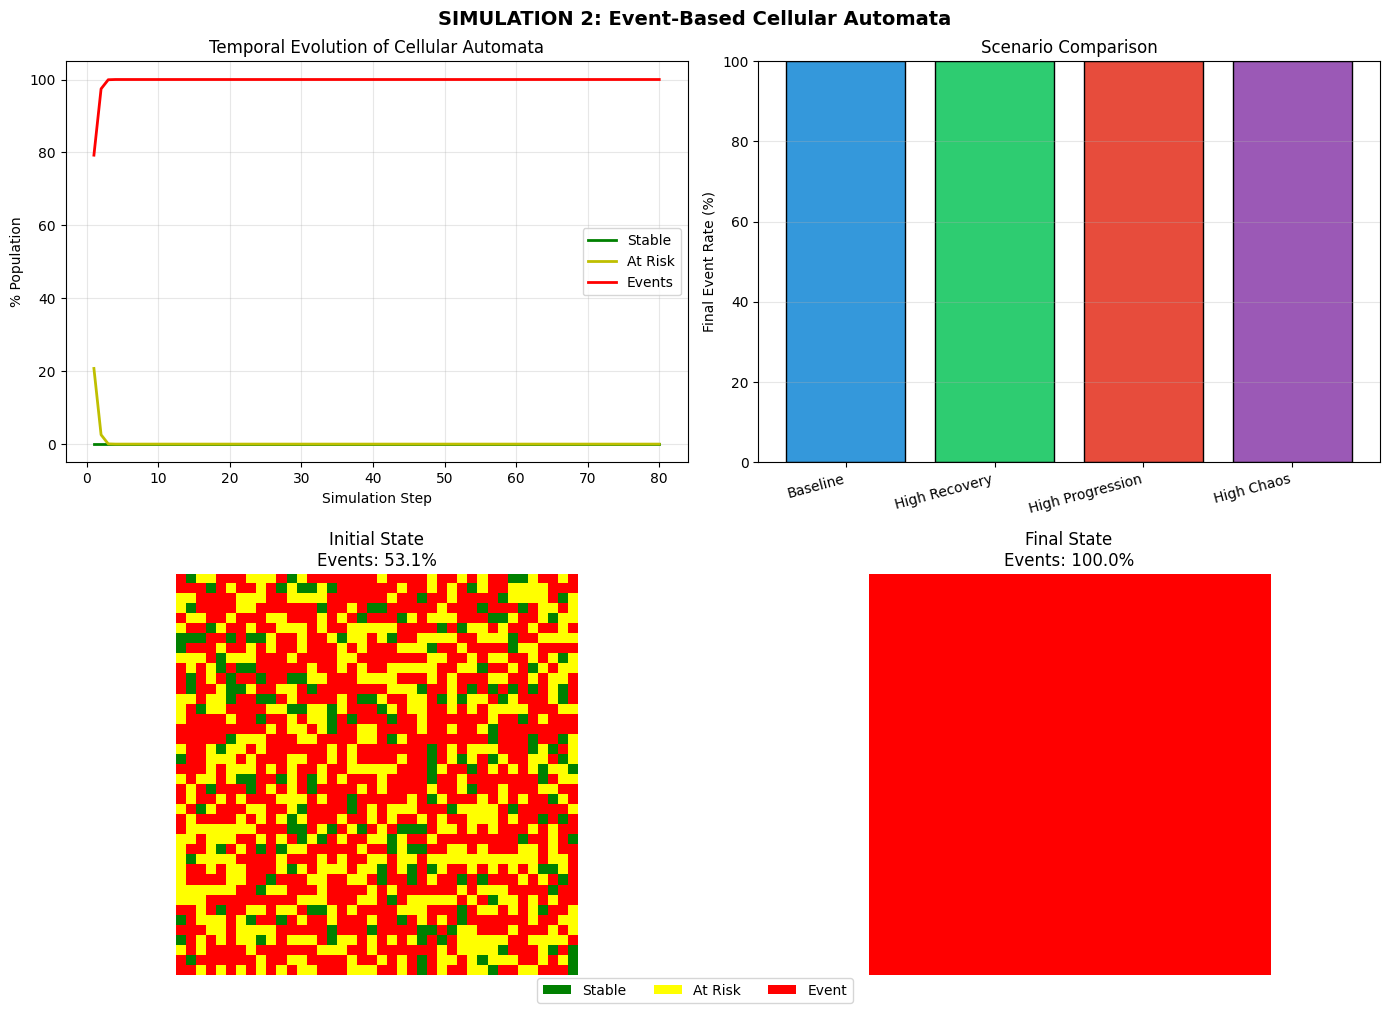


Plot saved: simulation2_results. png


In [10]:
# ==============================================================
# CELL 9: Visualizations
# ==============================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Temporal Evolution
ax1 = axes[0, 0]
ax1.plot(stats_df['step'], stats_df['stable_pct']*100, 'g-', linewidth=2, label='Stable')
ax1.plot(stats_df['step'], stats_df['risk_pct']*100, 'y-', linewidth=2, label='At Risk')
ax1.plot(stats_df['step'], stats_df['event_pct']*100, 'r-', linewidth=2, label='Events')
ax1.set_xlabel('Simulation Step')
ax1.set_ylabel('% Population')
ax1.set_title('Temporal Evolution of Cellular Automata')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Scenario Comparison
ax2 = axes[0, 1]
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']
bars = ax2.bar(scenario_df['scenario'], scenario_df['final_event_rate']*100, color=colors, edgecolor='black')
ax2.set_ylabel('Final Event Rate (%)')
ax2.set_title('Scenario Comparison')
ax2.set_ylim(0, 100)
ax2.grid(True, alpha=0.3, axis='y')
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=15, ha='right')

# Plot 3: Initial State
ax3 = axes[1, 0]
cmap = plt.cm.colors.ListedColormap(['green', 'yellow', 'red'])
ax3.imshow(ca.history[0], cmap=cmap, vmin=0, vmax=2)
ax3.set_title(f'Initial State\nEvents: {n_event/total*100:.1f}%')
ax3.axis('off')

# Plot 4: Final State
ax4 = axes[1, 1]
ax4.imshow(ca.grid, cmap=cmap, vmin=0, vmax=2)
ax4.set_title(f'Final State\nEvents: {final_event_rate*100:.1f}%')
ax4.axis('off')

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', label='Stable'),
    Patch(facecolor='yellow', label='At Risk'),
    Patch(facecolor='red', label='Event')
]
fig.legend(handles=legend_elements, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.02))

plt.suptitle('SIMULATION 2: Event-Based Cellular Automata', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('simulation2_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved: simulation2_results.png")

In [11]:
# ==============================================================
# CELL 10: Final Summary
# ==============================================================
print("\n" + "=" * 60)
print("SIMULATION 2 SUMMARY")
print("=" * 60)
print(f"Steps executed: {CA_STEPS}")
print(f"Grid size: {CA_GRID_SIZE}x{CA_GRID_SIZE}")
print(f"Initial event rate: {initial_event_rate:.4f}")
print(f"Final event rate: {final_event_rate:.4f}")
print(f"Observed trend: {trend}")
print(f"Scenarios compared: {len(scenarios)}")
print("=" * 60)


SIMULATION 2 SUMMARY
Steps executed: 80
Grid size: 40x40
Initial event rate: 0.5312
Final event rate: 1.0000
Observed trend: increasing
Scenarios compared: 4
Most influential factor: Recovery


>>> Sensitivity Analysis for Cellular Automata
    (Equivalent to SHAP for rule-based systems)



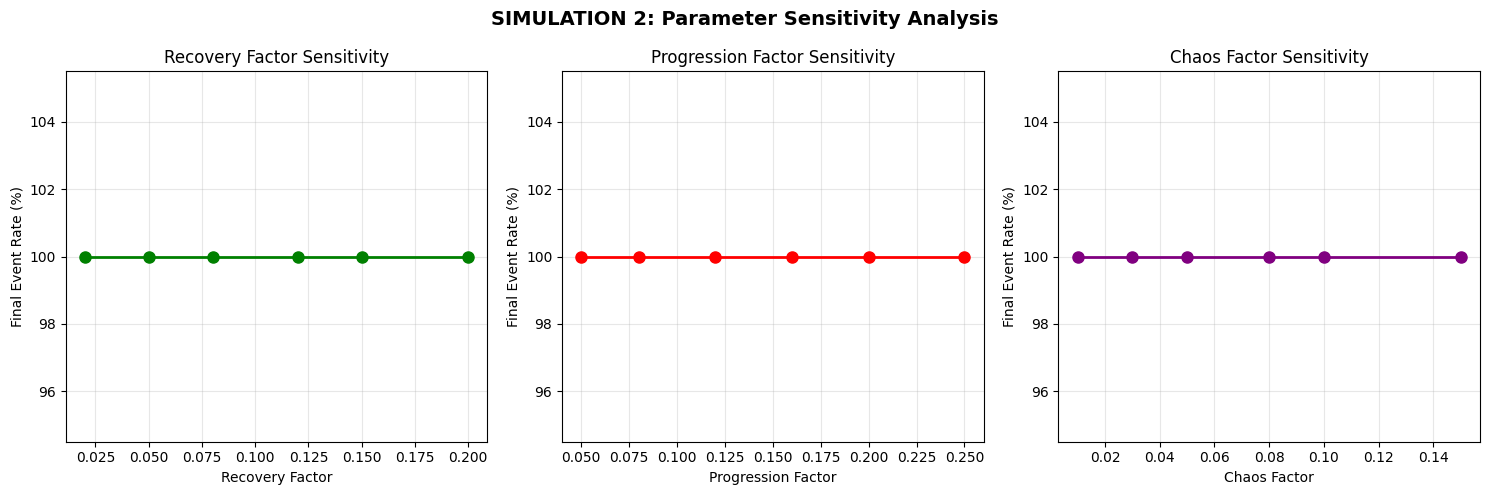


>>> Sensitivity Summary:
    Recovery: Range [100.0% - 100.0%], Impact = 0.0%
    Progression: Range [100.0% - 100.0%], Impact = 0.0%
    Chaos: Range [100.0% - 100.0%], Impact = 0.0%

Plot saved: sensitivity_simulation2.png


In [15]:
# ==============================================================
# CELL 11: Sensitivity Analysis for Cellular Automata
# ==============================================================
# Test how each parameter affects outcomes
# ==============================================================
print(">>> Sensitivity Analysis for Cellular Automata\n")

sensitivity_results = []

# Recovery factor sensitivity
print("   Testing recovery factor...")
for recovery in [0.02, 0.05, 0.08, 0.12, 0.15, 0.20]:
    ca_test = HCTCellularAutomata(grid_size=30, event_rate=event_rate)
    stats = ca_test.run_simulation(steps=50, recovery_factor=recovery,
        progression_factor=0.12, chaos_factor=0.03, verbose=False)
    sensitivity_results.append({
        'parameter': 'Recovery', 'value': recovery,
        'final_event_rate': stats.iloc[-1]['event_pct']
    })

# Progression factor sensitivity
print("   Testing progression factor...")
for progression in [0.05, 0.08, 0.12, 0.16, 0.20, 0.25]:
    ca_test = HCTCellularAutomata(grid_size=30, event_rate=event_rate)
    stats = ca_test.run_simulation(steps=50, recovery_factor=0.08,
        progression_factor=progression, chaos_factor=0.03, verbose=False)
    sensitivity_results.append({
        'parameter': 'Progression', 'value': progression,
        'final_event_rate': stats.iloc[-1]['event_pct']
    })

# Chaos factor sensitivity
print("   Testing chaos factor...")
for chaos in [0.01, 0.03, 0.05, 0.08, 0.10, 0.15]:
    ca_test = HCTCellularAutomata(grid_size=30, event_rate=event_rate)
    stats = ca_test.run_simulation(steps=50, recovery_factor=0.08,
        progression_factor=0.12, chaos_factor=chaos, verbose=False)
    sensitivity_results.append({
        'parameter': 'Chaos', 'value': chaos,
        'final_event_rate': stats.iloc[-1]['event_pct']
    })

sensitivity_df = pd.DataFrame(sensitivity_results)

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Recovery sensitivity
ax1 = axes[0]
data_recovery = sensitivity_df[sensitivity_df['parameter'] == 'Recovery']
ax1.plot(data_recovery['value'], data_recovery['final_event_rate']*100, 'o-', color='green', linewidth=2, markersize=8)
ax1.set_xlabel('Recovery Factor')
ax1.set_ylabel('Final Event Rate (%)')
ax1.set_title('Recovery Factor Sensitivity')
ax1.grid(True, alpha=0.3)

# Progression sensitivity
ax2 = axes[1]
data_progression = sensitivity_df[sensitivity_df['parameter'] == 'Progression']
ax2.plot(data_progression['value'], data_progression['final_event_rate']*100, 'o-', color='red', linewidth=2, markersize=8)
ax2.set_xlabel('Progression Factor')
ax2.set_ylabel('Final Event Rate (%)')
ax2.set_title('Progression Factor Sensitivity')
ax2.grid(True, alpha=0.3)

# Chaos sensitivity
ax3 = axes[2]
data_chaos = sensitivity_df[sensitivity_df['parameter'] == 'Chaos']
ax3.plot(data_chaos['value'], data_chaos['final_event_rate']*100, 'o-', color='purple', linewidth=2, markersize=8)
ax3.set_xlabel('Chaos Factor')
ax3.set_ylabel('Final Event Rate (%)')
ax3.set_title('Chaos Factor Sensitivity')
ax3.grid(True, alpha=0.3)

plt.suptitle('SIMULATION 2: Parameter Sensitivity Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('sensitivity_simulation2.png', dpi=150, bbox_inches='tight')
plt.show()

# Print summary
print("\n>>> Sensitivity Summary:")
for param in ['Recovery', 'Progression', 'Chaos']:
    data = sensitivity_df[sensitivity_df['parameter'] == param]
    min_rate = data['final_event_rate'].min()
    max_rate = data['final_event_rate'].max()
    impact = max_rate - min_rate
    print(f"    {param}: Range [{min_rate*100:.1f}% - {max_rate*100:.1f}%], Impact = {impact*100:.1f}%")

print("\nPlot saved: sensitivity_simulation2.png")